In [9]:
import os
import pickle
from dataclasses import dataclass, field
from typing import Annotated, Literal, cast

from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.types import Command
from pydantic import BaseModel, Field

In [10]:
# -----------------------------------------------------------------------------
# Environment and Global Configuration
# -----------------------------------------------------------------------------

if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("Please set OPENAI_API_KEY environment variable")

EMBEDDING_MODEL = "text-embedding-3-small"
RETRIEVAL_K = 3

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

MAX_ITERATIONS = 10

In [11]:
# -----------------------------------------------------------------------------
# Utility Functions for Document Handling
# -----------------------------------------------------------------------------


def load_documents(pickle_filepath: str) -> list[Document]:
    """Load documents from a pickle file."""
    with open(pickle_filepath, "rb") as file:
        return pickle.load(file)


def initialize_vector_store(document_chunks: list[Document]) -> Chroma:
    """Reset the Chroma collection and initialize a vector store using document chunks."""
    Chroma().reset_collection()
    embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL)
    return Chroma.from_documents(documents=document_chunks, embedding=embedding_model)


def deduplicate_documents(documents: list[Document]) -> list[Document]:
    """Remove duplicate documents based on their unique identifier."""
    unique_docs = {doc.id: doc for doc in documents}
    return list(unique_docs.values())

In [12]:
# -----------------------------------------------------------------------------
# Document Preparation and Retriever Setup
# -----------------------------------------------------------------------------

# For demonstration, load and process a subset of documents.
documents = load_documents("bloomberg_financial_news.pkl")
# chunked_documents = split_documents(documents[:10])

In [13]:
# Initialize vector store and create a retriever.
vector_store = initialize_vector_store(documents[:1000])
retriever = vector_store.as_retriever(search_kwargs={"k": RETRIEVAL_K})

In [14]:
# -----------------------------------------------------------------------------
# Workflow State Definition
# -----------------------------------------------------------------------------

import operator


class ResearchTask(BaseModel):
    """Task for the financial analysis workflow."""

    topic: str = Field(description="Topic of the research task.")
    description: str = Field(description="Brief description of the task and its objectives.")


class OrchestratorDecision(BaseModel):
    """List of research tasks for the financial analysis workflow."""

    response: str = Field(description="Rationale for the decision and research tasks.")
    in_scope: bool = Field(description="Wether the client request is in scope for the financial analysis.")
    research_tasks: list[ResearchTask] | None = Field(description="List of research tasks to be completed.")


@dataclass(kw_only=True)
class WorkflowState:
    """Graph state tracking for the financial analysis workflow."""

    messages: Annotated[list, add_messages] = field(default_factory=list)
    analyses: Annotated[list, operator.add] = field(default_factory=list)


@dataclass(kw_only=True)
class ResearchState:
    """Graph state tracking for the financial analysis workflow."""

    task: ResearchTask

In [15]:
base_model = ChatOpenAI(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

In [16]:
from langgraph.constants import Send

In [17]:
# -----------------------------------------------------------------------------
# CIA Agent
# -----------------------------------------------------------------------------

CIA_PROMPT = """
You are a Client Interface Agent (CIA) in a financial analysis system. You have multiple Research Agents with access to Bloomberg Financial News under your supervision.

Given a client request, provide a concise, polite and professional response regarding the feasibility of the request and the approach that will be taken to address it.

If the user's request is addressable, create a short list of highly specific research topics that the Research Agents will investigate to fulfill the client's request.
"""

cia_model = base_model.with_structured_output(OrchestratorDecision)


def cia(state: WorkflowState) -> Command[Literal["research", END]]:
    """Orchestrator that generates a plan for the report."""
    orchestrator_output = cia_model.invoke(
        [
            SystemMessage(CIA_PROMPT),
            *state.messages,
        ]
    )
    print(orchestrator_output)

    return Command(
        update={"messages": orchestrator_output.response},
        goto=[Send("research", ResearchState(task=task)) for task in orchestrator_output.research_tasks]
        if orchestrator_output.in_scope
        else END,
    )

In [18]:
from langchain_core.tools import tool


@tool
def retrieval(retrieval_query: str) -> list[Document]:
    """Retrieve documents based on a query."""
    return retriever.invoke(retrieval_query)


tools = [retrieval]
tools_by_name = {tool.name: tool for tool in tools}

In [19]:
BRA_PROMPT = """
You are a Research Agent in a financial analysis system. You are tasked with writing a concise research report on a specific topic provided by the Client Interface Agent (CIA) based on available documents.

To do so, you have access to a Bloomberg Financial News database that you can query. You should query the vector store for documents relevant to your task and write a concise summary of the information you find.

Your report should be short and informative, conveying only the most important information from the documents, to allow a Synthesis Agent to quikcly generate a report for the client based on the findings of all Research Agents.

"""

bra_model = base_model.bind_tools([retrieval])

In [20]:
def bra(state: ResearchState) -> Command[Literal["synthesizer"]]:
    """Research agent that can query the vector store for relevant documents."""
    research = bra_model.invoke(
        [
            SystemMessage(BRA_PROMPT),
            HumanMessage(f"Research Task: {state.task.topic}\n\n Description: {state.task.description}"),
        ]
    )

    if research.tool_calls:
        tool_call = research.tool_calls[0]
        tool = tools_by_name[tool_call["name"]]
        documents = tool.invoke(tool_call["args"])

        print([doc.metadata["Headline"] for doc in documents])

        research = base_model.invoke(
            [
                SystemMessage(BRA_PROMPT),
                HumanMessage(f"Research Task: {state.task.topic}\n\n Description: {state.task.description}"),
                research,
                ToolMessage(
                    content="\n\n".join([f"{doc.metadata['Headline']}\n{doc.page_content}" for doc in documents]),
                    tool_call_id=tool_call["id"],
                ),
            ]
        )

    print(research.content)

    return Command(
        update={"analyses": [research.content]},
        goto="synthesizer",
    )

In [21]:
MSSA_PROMPT = """
You are a Market Strategist & Synthesis Agent (MSSA) in a financial analysis system. You have access to the analysis reports generated by the Research Agents, and are tasked with synthesizing the information into a final report for the client.

You should cross-reference the analyses and write a final report that covers the key findings in a clear and concise manner to address the client's request.
"""

In [22]:
def mssa(state: WorkflowState) -> Command[Literal[END]]:
    """Synthesize full report from research analyses."""
    analyses_reports = state.analyses

    complete_analyses = "\n\n---\n\n".join(analyses_reports)

    synthesizer_output = base_model.invoke(
        [
            SystemMessage(MSSA_PROMPT),
            *state.messages,
            HumanMessage(complete_analyses),
        ]
    )
    print(synthesizer_output.content)

    return Command(
        update={"messages": synthesizer_output},
        goto=END,
    )

In [23]:
# Build workflow
graph_builder = StateGraph(WorkflowState)

# Add the nodes
graph_builder.add_node("orchestrator", cia)
graph_builder.add_node("research", bra)
graph_builder.add_node("synthesizer", mssa)

graph_builder.set_entry_point("orchestrator")

# # Add edges to connect nodes
# graph_builder.add_edge(START, "orchestrator")
# graph_builder.add_conditional_edges("orchestrator", assign_workers, ["research"])
# graph_builder.add_edge("research", "synthesizer")
# graph_builder.add_edge("synthesizer", END)

# Compile the workflow
app = graph_builder.compile()

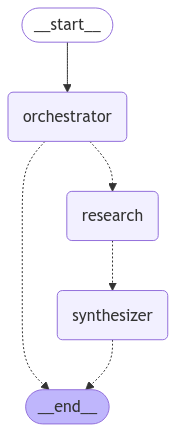

In [24]:
from IPython.display import Image

# Show the workflow
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
# Invoke
state = app.invoke(
    {"messages": "I want to invest in the technology sector. Can you please define an investment strategy?"}
)

response='Investing in the technology sector can be a lucrative opportunity, but it requires a well-defined strategy to navigate the market effectively. We will conduct research to identify key trends, potential growth areas, and risk factors within the technology sector. Our approach will include analyzing current market conditions, evaluating leading companies, and exploring emerging technologies.' in_scope=True research_tasks=[ResearchTask(topic='Market Trends in Technology Sector', description='Investigate current trends affecting the technology sector, including AI, cloud computing, and cybersecurity.'), ResearchTask(topic='Top Performing Technology Stocks', description='Identify and analyze the top-performing stocks in the technology sector over the past year.'), ResearchTask(topic='Investment Risks in Technology', description='Assess the potential risks associated with investing in technology companies, including market volatility and regulatory challenges.'), ResearchTask(topic

In [26]:
from IPython.display import Markdown

Markdown(state["messages"][-1].content)

### Final Investment Strategy Report: Technology Sector

#### Executive Summary
The technology sector presents a compelling investment opportunity, driven by transformative trends in artificial intelligence (AI), cloud computing, and cybersecurity. This report synthesizes key findings from recent analyses, highlighting growth areas, top-performing stocks, potential risks, and emerging technologies. A strategic approach to investing in this sector will focus on leveraging these insights to maximize returns while managing associated risks.

#### Key Trends and Growth Areas

1. **Artificial Intelligence (AI)**
   - AI is revolutionizing various industries, enhancing operational efficiencies and creating new business models. Companies integrating AI into their offerings are likely to see improved customer engagement and competitive advantages.

2. **Cloud Computing**
   - The shift towards cloud-based solutions is accelerating, with businesses seeking scalability and flexibility. This trend is particularly strong in IT outsourcing, indicating robust growth potential for companies providing cloud services.

3. **Cybersecurity**
   - With increasing cyber threats, investment in cybersecurity solutions is critical. Companies like Palo Alto Networks are leading the charge, reporting significant revenue growth and expanding their market share. The enterprise firewall market is projected to grow by 11%, underscoring the demand for advanced security measures.

4. **Emerging Technologies and Startups**
   - The IPO landscape in Japan is set to flourish, particularly in technology sectors such as information technology, social networking, and gaming. This presents opportunities for early investments in promising startups.

#### Top Performing Stocks

1. **Palo Alto Networks (PANW)**
   - A leader in cybersecurity, with a 70% revenue increase and a strong market position. The company is well-positioned to benefit from the growing demand for security solutions.

2. **Celestica Inc. (CLS)**
   - With a 31% stock rise in 2023 and strong earnings performance, Celestica is capitalizing on demand in the communications segment, indicating a positive growth trajectory.

3. **TT Electronics Plc (TTG)**
   - Gaining 18% this year, TT Electronics is expected to benefit from growth in the automotive sector and ongoing restructuring efforts.

#### Investment Risks

1. **Market Volatility**
   - The technology sector is prone to fluctuations, influenced by broader economic conditions and investor sentiment. Recent earnings disappointments from major firms have led to stock price declines, highlighting the need for cautious investment.

2. **Regulatory Challenges**
   - Increasing scrutiny from regulators regarding data privacy and antitrust issues poses risks for technology companies. Compliance with evolving regulations can impact operational costs and market stability.

3. **Earnings Performance**
   - The unpredictability of earnings in the technology sector can lead to significant stock price volatility. Investors should closely monitor earnings reports and market reactions.

#### Investment Strategy Recommendations

1. **Diversification**
   - Build a diversified portfolio that includes a mix of established companies and emerging startups within the technology sector. Focus on sectors with strong growth potential, such as AI, cloud computing, and cybersecurity.

2. **Focus on Innovation**
   - Invest in companies that prioritize innovation and adaptability to market changes. Look for firms that are actively integrating AI and cloud solutions into their business models.

3. **Monitor Market Conditions**
   - Stay informed about market trends and economic indicators that may affect the technology sector. Regularly review earnings reports and adjust the investment strategy accordingly.

4. **Consider Emerging Markets**
   - Explore opportunities in emerging markets, particularly in Japan, where the IPO landscape is expanding. Investing in promising startups can yield significant returns as these companies grow.

#### Conclusion
The technology sector offers substantial growth opportunities, driven by key trends in AI, cloud computing, and cybersecurity. By adopting a strategic investment approach that emphasizes diversification, innovation, and market awareness, investors can effectively navigate the complexities of this dynamic sector while mitigating risks.